In [6]:
# Build the neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
import os

dir = "trained_agents"
if not os.path.exists(dir):
    os.makedirs(dir)

class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  
    
    def __len__(self):
        return len(self.memory)


class FrozenLake():
    # Hyperparameters
    lr = 0.005 # Learning rate
    epsilon_rate = 1 # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9 # Discount factor
    update_rate = 10 # Update target network every 10 episodes
    replay_memory_size = 1000 # Replay memory size
    batch_size = 64 # Number of samples to take from replay memory
    checkpoint_episode = 200 # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U'] # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQNetwork(states, actions)
        target_net = DQNetwork(states, actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes)

        epsilon_rate_history = []

        steps = 0

        for episode in range(episodes): # Loop through episodes
            state = env.reset()[0]
            done = False # True if agent stepped on a hole or reached the goal
            stop = False # True if agent takes too long to solve the environment

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad(): # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()
                
                new_state, reward, done, stop, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                steps += 1

            if reward == 1:
                rewards_per_episode[episode] = 1

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size) # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net) # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"{dir}/policy_net{episode}.pth")
                
        env.close()


    def state_to_dqn_input(self, state:int, states:int)->torch.Tensor:
        '''
        Converts a state to a tensor that can be used as input to the DQN (encoded as one-hot)
        '''	
        input_tensor = torch.zeros(states)
        state = int(state)
        input_tensor[state] = 1
        return input_tensor

    
    def optimize(self, batch, policy_net, target_net):

        states = policy_net.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state, states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state, states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state, states))
            # Adjust the specific action to the target that was just calculated. 
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human')
        states = env.observation_space.n
        actions = env.action_space.n

        # Load learned policy
        policy_net = DQNetwork(states, actions)
        policy_net.load_state_dict(torch.load("policy_net.pth"))
        policy_net.eval()    # switch model to evaluation mode

       
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            done = False      # True when agent falls in hole or reached goal
            stop = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (done), reaches goal (done), or has taken 200 actions (stop).
            while(not done and not stop):  
                # Select best action   
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()

                # Execute action
                state,reward,done,stop,_ = env.step(action)

        env.close()

if __name__ == '__main__':

    frozen_lake = FrozenLake()
    is_slippery = False
    frozen_lake.train(2000, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)


In [10]:
class FrozenLake():
    # Hyperparameters
    lr = 0.003 # Learning rate
    epsilon_rate = 1 # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9 # Discount factor
    update_rate = 10 # Update target network every 10 episodes
    replay_memory_size = 500 # Replay memory size
    batch_size = 64 # Number of samples to take from replay memory
    checkpoint_episode = 200 # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U'] # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQNetwork(states, actions)
        target_net = DQNetwork(states, actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes+1)

        epsilon_rate_history = []
        returns = [] # List to store returns for each episode

        steps = 0

        for episode in range(1, episodes+1): # Loop through episodes
            state = env.reset()[0]
            done = False # True if agent stepped on a hole or reached the goal
            stop = False # True if agent takes too long to solve the environment
            total_reward = 0

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad(): # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()
                
                new_state, reward, done, stop, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                total_reward += reward
                steps += 1

            rewards_per_episode[episode] = total_reward
            returns.append(total_reward) # Track the return

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size) # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net) # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"policy_net{episode}.pth")
                
        env.close()
        return returns

    def state_to_dqn_input(self, state:int, states:int)->torch.Tensor:
        '''
        Converts a state to a tensor that can be used as input to the DQN (encoded as one-hot)
        '''	
        input_tensor = torch.zeros(states)
        state = int(state)
        input_tensor[state] = 1
        return input_tensor

    
    def optimize(self, batch, policy_net, target_net):

        states = policy_net.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state, states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state, states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state, states))
            # Adjust the specific action to the target that was just calculated. 
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def test(self, episodes, render=True, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        # Load learned policy
        policy_net = DQNetwork(states, actions)
        policy_net.load_state_dict(torch.load("policy_net2000.pth"))
        policy_net.eval()    # switch model to evaluation mode

        total_rewards = []  # To track rewards over episodes
        
        for i in range(1, episodes+1):
            state = env.reset()[0]  # Initialize to state 0
            done = False      # True when agent falls in hole or reached goal
            stop = False       # True when agent takes more than 200 actions
            total_reward = 0  # To track total reward per episode            

            # Agent navigates map until it falls into a hole (done), reaches goal (done), or has taken 200 actions (stop).
            while(not done and not stop):  
                # Select best action   
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()

                # Execute action
                state, reward, done, stop, _ = env.step(action)
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Episode {i}: Total Reward: {total_reward}")

        env.close()
        return total_rewards

        average_return = np.mean(total_rewards)
        print(f"Average return over {episodes} episodes: {average_return}")

        return total_rewards, average_return


Training on non-slippery FrozenLake
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 0.0, epsilon: 0.99
episode: 5/2000, return: 0.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 0.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.

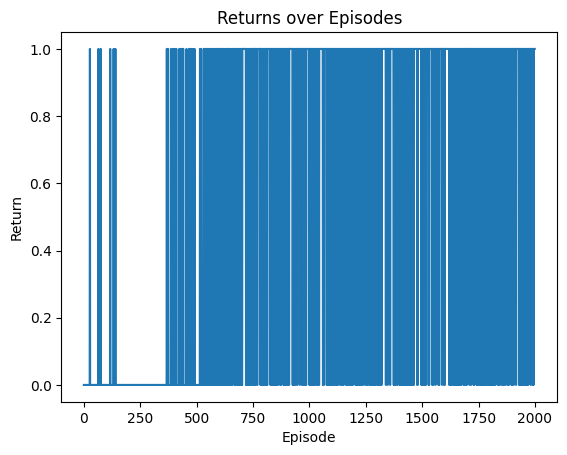

In [11]:
# Train the model and get returns
fl = FrozenLake()
returns = fl.train(episodes=2000, render=False, is_slippery=False)

# Plot the returns
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

In [12]:
# Evaluate the model
test_rewards = fl.test(episodes=10, render=True, is_slippery=False)


Episode 1: Total Reward: 0.0
Episode 2: Total Reward: 0.0
Episode 3: Total Reward: 0.0
Episode 4: Total Reward: 0.0
Episode 5: Total Reward: 0.0
Episode 6: Total Reward: 0.0
Episode 7: Total Reward: 0.0
Episode 8: Total Reward: 0.0
Episode 9: Total Reward: 0.0
Episode 10: Total Reward: 0.0
